# Document Tagging: BBC News Articles 

This corpus used in this project includes 2,225 documents from BBC's news website corresponding to stories in five topical areas (business, entertainment, politics, sport, tech) from 2004-2005. 

The CSV file includes two columns: category (the five class labels) and text (pre-processed article content). In this project, I will use only the text column.

More information on this data set as well as a paper written using this data set is available here http://mlg.ucd.ie/datasets/bbc.html.

## Data Prep

### Import Libraries

In [1]:
import pprint
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import gensim

import random
random.seed(42)

### Load Data

In [2]:
df = pd.read_csv("data/BBC-articles.csv")
df = df[['text']][:100]
df.head(3)

,text
0,tv future in the hands of viewers with home th...
1,worldcom boss left books alone former worldc...
2,tigers wary of farrell gamble leicester say ...


### Initial Prep

In [3]:
'''
This function takes as input a df and name of column (containing sentences) in the df.
The input is split to tokens which are lemmatized, and stopwords removed.
The output is a list of lists.  
'''
import re
def preprocess_text(text):    
    cleanTokens=[]
    lem = WordNetLemmatizer()
    stop = set(stopwords.words('english'))

    for txt in text:
        words = [lem.lemmatize(w) for w in word_tokenize(txt) if (w not in stop) and len(w)>2]
        cleanTokens.append(words)        

    return cleanTokens


df['cleanTokens'] = preprocess_text(df.text)

## Modeling

In [4]:
# Getting tokens to use with Gensim
tokens = df.cleanTokens.to_list()

In [5]:
'''
This function takes as input a string of text and returns a list of nouns, noun phrases and named entities.
The function has a high complexity, and there may be more efficient ways to go about it.
However, this gives me the output I desire the compared to available methods/packages.
'''
import nltk
# nltk.download('brown')
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('maxent_ne_chunker')
# nltk.download('words')

from nltk import ne_chunk, pos_tag, sent_tokenize, word_tokenize
from nltk.tree import Tree

def getNouns(text):
    global nouns
    nouns = []

    for sentence in sent_tokenize(text):
        for word, pos in pos_tag(word_tokenize(sentence)):
            if (pos == 'NN' or pos == 'NNP' or pos == 'NNS' or pos == 'NNPS'):
                nouns.append(word)

        chunked = ne_chunk(pos_tag(word_tokenize(sentence)))
        continuous_chunk = []
        current_chunk = []
        for i in chunked:
                if type(i) == Tree:
                        current_chunk.append(" ".join([token for token, pos in i.leaves()]))
                if current_chunk:
                        named_entity = " ".join(current_chunk)
                        if named_entity not in nouns:
                                nouns.append(named_entity)
                                current_chunk = []
                else:
                        continue
    return nouns

In [8]:
df['nouns'] = df.text.apply(lambda x: getNouns(x))

In [9]:
from gensim.corpora import Dictionary
from gensim.models import TfidfModel

# TF-IDF with basic cleaning
dictionaryLtd = Dictionary(tokens)
dtmLtd = [dictionaryLtd.doc2bow(doc) for doc in tokens]
tfidfVectorizerLtd = TfidfModel(dtmLtd) 
tfidfLtd = tfidfVectorizerLtd[dtmLtd]

# TF-IDF with term frequency filter cleaning
dictionaryFiltered = Dictionary(tokens)
dictionaryFiltered.filter_extremes(no_below=5, no_above=0.90)
dtmFiltered = [dictionaryFiltered.doc2bow(doc) for doc in tokens]
tfidfVectorizerFiltered = TfidfModel(dtmFiltered) 
tfidfFiltered = tfidfVectorizerFiltered[dtmFiltered]

# TF-IDF with only nouns, noun phrases and NER
dictionaryNouns = Dictionary(df.nouns)
dtmNouns = [dictionaryNouns.doc2bow(doc) for doc in df.nouns]
tfidfVectorizerNouns = TfidfModel(dtmNouns) 
tfidfNouns = tfidfVectorizerNouns[dtmNouns]

### LSI

In [10]:
from gensim.models import LsiModel, CoherenceModel

# tfidfLtd
lsi_Ltd = LsiModel(corpus=tfidfLtd, id2word=dictionaryLtd, num_topics=10)

# tfidfFiltered
lsi_Filtered = LsiModel(corpus=tfidfFiltered, id2word=dictionaryFiltered, num_topics=10)

# tfidfNouns
lsi_Nouns = LsiModel(corpus=tfidfNouns, id2word=dictionaryNouns, num_topics=10)

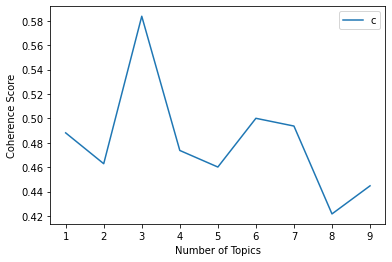

In [11]:
# Determining optimum number of topics using coherence values for tfidfLtd

coherence_values = []
model_list = []
min_topics, max_topics, step = 1, 10, 1
for i in range(min_topics, max_topics, step):
    model = LsiModel(tfidfLtd, id2word=dictionaryLtd, num_topics=i)
    model_list.append(model)
    coherencemodel = CoherenceModel(model=model, texts=tokens, \
        dictionary=dictionaryLtd, coherence='c_v')
    coherence_values.append(coherencemodel.get_coherence())


import matplotlib.pyplot as plt
x = range(min_topics, max_topics, step)
plt.plot(x, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.legend(("coherence_values"), loc="best")
plt.show()

For TFIDF the best model is when topics = 2

In [12]:
# tfidfLtd with the optimum number of topics
lsi_Ltd = LsiModel(corpus=tfidfLtd, id2word=dictionaryLtd, num_topics=2)

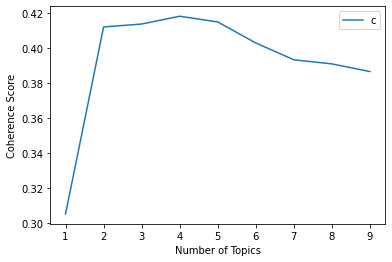

In [13]:
# Determining optimum number of topics using coherence values for tfidfFiltered

coherence_values = []
model_list = []
min_topics, max_topics, step = 1, 10, 1
for i in range(min_topics, max_topics, step):
    model = LsiModel(tfidfFiltered, id2word=dictionaryFiltered, num_topics=i)
    model_list.append(model)
    coherencemodel = CoherenceModel(model=model, texts=tokens, \
        dictionary=dictionaryFiltered, coherence='c_v')
    coherence_values.append(coherencemodel.get_coherence())


import matplotlib.pyplot as plt
x = range(min_topics, max_topics, step)
plt.plot(x, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.legend(("coherence_values"), loc="best")
plt.show()

For TFIDF using filtered data the best model is when topics = 4

In [14]:
# tfidfFiltered with the optimum number of topics
lsi_Filtered = LsiModel(corpus=tfidfFiltered, id2word=dictionaryFiltered, num_topics=4)

C:\Users\echemochek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\echemochek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


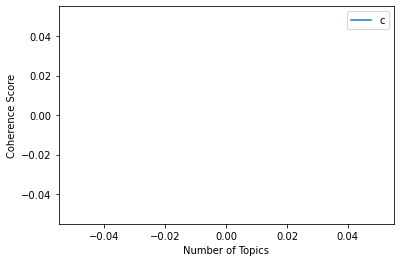

In [15]:
# Determining optimum number of topics using coherence values for tfidfNouns

coherence_values = []
model_list = []
min_topics, max_topics, step = 1, 10, 1
for i in range(min_topics, max_topics, step):
    model = LsiModel(tfidfNouns, id2word=dictionaryNouns, num_topics=i)
    model_list.append(model)
    coherencemodel = CoherenceModel(model=model, texts=tokens, \
        dictionary=dictionaryNouns, coherence='c_v')
    coherence_values.append(coherencemodel.get_coherence())


import matplotlib.pyplot as plt
x = range(min_topics, max_topics, step)
plt.plot(x, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.legend(("coherence_values"), loc="best")
plt.show()

### LDA

In [16]:
from gensim.models import LdaModel, LdaMulticore

# tfidfLtd
lda_Ltd = LdaModel(corpus=tfidfLtd, id2word=dictionaryLtd, num_topics=10)

# tfidfFiltered
lda_Filtered = LdaModel(corpus=tfidfFiltered, id2word=dictionaryFiltered, num_topics=10)

# tfidfNouns
lda_Nouns = LdaModel(corpus=tfidfNouns, id2word=dictionaryNouns, num_topics=10)

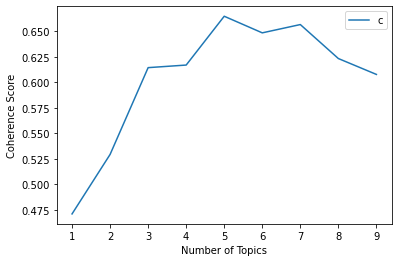

In [17]:
# Determining optimum number of topics using coherence values for tfidfLtd 

coherence_values = []
model_list = []
min_topics, max_topics, step = 1, 10, 1
for i in range(min_topics, max_topics, step):
    model = LdaModel(tfidfLtd, id2word=dictionaryLtd, num_topics=i)
    model_list.append(model)
    coherencemodel = CoherenceModel(model=model, texts=tokens, \
        dictionary=dictionaryLtd, coherence='c_v')
    coherence_values.append(coherencemodel.get_coherence())


import matplotlib.pyplot as plt
x = range(min_topics, max_topics, step)
plt.plot(x, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.legend(("coherence_values"), loc="best")
plt.show()

For TFIDF using unfiltered data the best model is when topics = 4

In [18]:
# tfidfLtd with the optimum number of topics
lda_Ltd = LdaModel(corpus=tfidfLtd, id2word=dictionaryLtd, num_topics=7)

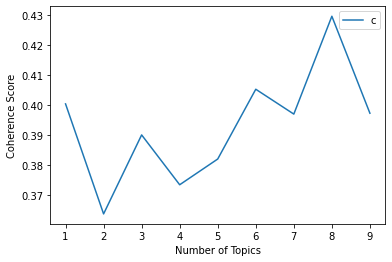

In [19]:
# Determining optimum number of topics using coherence values for tfidfFiltered

coherence_values = []
model_list = []
min_topics, max_topics, step = 1, 10, 1

for i in range(min_topics, max_topics, step):
    model = LdaModel(tfidfFiltered, id2word=dictionaryFiltered, num_topics=i)
    model_list.append(model)
    coherencemodel = CoherenceModel(model=model, texts=tokens, \
        dictionary=dictionaryFiltered, coherence='c_v')
    coherence_values.append(coherencemodel.get_coherence())


import matplotlib.pyplot as plt
x = range(min_topics, max_topics, step)
plt.plot(x, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.legend(("coherence_values"), loc="best")
plt.show()

For TFIDF using unfiltered data the best model is when topics = 7

In [20]:
# tfidfFiltered with the optimum number of topics
lda_Filtered = LdaModel(corpus=tfidfFiltered, id2word=dictionaryFiltered, num_topics=8)

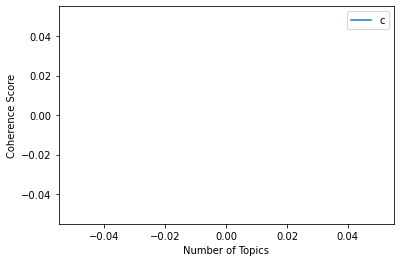

In [21]:
# Determining optimum number of topics using coherence values for tfidfFiltered

coherence_values = []
model_list = []
min_topics, max_topics, step = 1, 10, 1
for i in range(min_topics, max_topics, step):
    model = LdaModel(tfidfNouns, id2word=dictionaryNouns, num_topics=i)
    model_list.append(model)
    coherencemodel = CoherenceModel(model=model, texts=tokens, \
        dictionary=dictionaryNouns, coherence='c_v')
    coherence_values.append(coherencemodel.get_coherence())


import matplotlib.pyplot as plt
x = range(min_topics, max_topics, step)
plt.plot(x, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.legend(("coherence_values"), loc="best")
plt.show()

### LDA Interactive

In [22]:
# interacting with LDA output
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

pyLDAvis.enable_notebook()

vis = gensimvis.prepare(lda_Ltd, tfidfLtd, dictionaryLtd)
vis

C:\Users\echemochek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\past\builtins\misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
C:\Users\echemochek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.012235 -0.001131       1        1  20.401895
2      0.002207  0.009136       2        1  17.048197
5      0.003927 -0.007935       3        1  15.422614
6      0.004074 -0.000813       4        1  14.086405
4      0.001709 -0.000157       5        1  12.742042
0     -0.000599  0.000062       6        1  10.585544
3      0.000918  0.000837       7        1   9.713302, topic_info=         Term      Freq     Total Category  logprob  loglift
1358    hague  0.000000  0.000000  Default  30.0000  30.0000
4961      fox  0.000000  0.000000  Default  29.0000  29.0000
786     human  0.000000  0.000000  Default  28.0000  28.0000
785    howard  0.000000  0.000000  Default  27.0000  27.0000
4303     fiat  0.000000  0.000000  Default  26.0000  26.0000
...       ...       ...       ...      ...      ...      ...
3019     rate  0.048689  0.294752   Topic7  -7.4680   0.5310
387      club  0.043749  0.288407   Topic7  -7.5750   0.4458
1483     bank  0.041323  0.277959   Topic7  -7.6321   0.4256
151      news  0.037350  0.221508   Topic7  -7.7331   0.5516
473   chelsea  0.036219  0.195135   Topic7  -7.7639   0.6476

[308 rows x 6 columns], token_table=Empty DataFrame
Columns: [Topic, Freq, Term]
Index: [], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 6, 7, 5, 1, 4])

### Top keywords

In [23]:
# Add top keywords to dataframe as new column for each model
keywords = []
for i in range(len(tfidfLtd)):    
    for index, score in sorted(lda_Ltd[tfidfLtd[i]], key=lambda tup: -1*tup[1]):
        elements = lda_Ltd.print_topic(index, 5).split("+")
        keywords.append([x.strip().replace('"', '').split("*")[1] for x in elements])

In [24]:
# Add top keywords to dataframe as new column for each model
def addKeywords(model, corpus):
    n = len(corpus)
    keywords = []

    for i in range(n):    
        for index, score in sorted(model[corpus[i]], key=lambda tup: -1*tup[1]):
            elements = model.print_topic(index, 5).split("+")
            keywords.append([x.strip().replace('"', '').split("*")[1] for x in elements])
    
    return keywords[:n]

In [29]:
# add keywords to df
df["LSI_Ltd"] = addKeywords(lsi_Ltd, tfidfLtd)
df["LSI_Filtered"] = addKeywords(lsi_Filtered, tfidfFiltered)
df["LSI_Nouns"] = addKeywords(lsi_Nouns, tfidfNouns)
df["LDA_Ltd"] = addKeywords(lda_Ltd, tfidfLtd)
df["LDA_Filtered"] = addKeywords(lda_Filtered, tfidfFiltered)
df["LDA_Nouns"] = addKeywords(lda_Nouns, tfidfNouns)

In [32]:
df.head()

,text,cleanTokens,nouns,LSI_Ltd,LSI_Filtered,LSI_Nouns,LDA_Ltd,LDA_Filtered,LDA_Nouns
0,tv future in the hands of viewers with home th...,"[future, hand, viewer, home, theatre, system, ...","[tv, future, hands, viewers, home, theatre, sy...","[party, hague, government, price, people]","[party, people, film, club, government]","[hague, %, i, growth, party]","[human, fiat, argonaut, hendrix, ice]","[club, show, technology, bbc, debt]","[hague, rates, growth, robinson, gorges]"
1,worldcom boss left books alone former worldc...,"[worldcom, bos, left, book, alone, former, wor...","[worldcom, boss, books, worldcom, bernie, ebbe...","[hague, party, front, ambition, leadership]","[film, party, match, award, cup]","[henman, moya, seed, ljubicic, federer]","[film, broadband, west, henman, e-mail]","[share, lord, news, quarter, economy]","[virgin, sayeed, ranieri, ebbers, vioxx]"
2,tigers wary of farrell gamble leicester say ...,"[tiger, wary, farrell, gamble, leicester, say,...","[tigers, farrell, leicester, bid, andy, farrel...","[party, hague, government, price, people]","[party, price, growth, rate, election]","[hague, parties, donations, government, people]","[rugby, hague, ukraine, dicaprio, panda]","[music, union, left, service, howard]","[hague, rates, growth, robinson, gorges]"
3,yeading face newcastle in fa cup premiership s...,"[yeading, face, newcastle, cup, premiership, s...","[face, newcastle, cup, side, face, trip, leagu...","[hague, party, front, ambition, leadership]","[film, match, cup, rugby, league]","[oil, barrel, prices, yukos, growth]","[music, solskjaer, pernod, debt, child]","[court, party, government, coach, cup]","[oil, prices, gm, barrel, wilkinson]"
4,ocean s twelve raids box office ocean s twelve...,"[ocean, twelve, raid, box, office, ocean, twel...","[s, twelve, raids, box, office, ocean, crime, ...","[party, hague, government, price, people]","[party, people, film, club, government]","[hague, party, growth, %, prices]","[fox, pension, virgin, blue, bates]","[ambition, rate, wale, policy, party]","[traffic, parker, yukos, audio, technology]"


In [ ]:
# Evaluating LDA models: Topic coherence
from gensim.models import CoherenceModel

goodLdaModel = LdaModel(corpus=tfidfNouns, id2word=dictionaryNouns, iterations=50, num_topics=2)
badLdaModel = LdaModel(corpus=tfidfNouns, id2word=dictionaryNouns, iterations=1, num_topics=2)

goodcm = CoherenceModel(model=goodLdaModel, corpus=tfidfNouns, dictionary=dictionaryNouns, coherence='u_mass')
badcm  = CoherenceModel(model=badLdaModel, corpus=tfidfNouns, dictionary=dictionaryNouns, coherence='u_mass')

In [ ]:
goodcm = CoherenceModel(model=goodLdaModel, texts=tfidfNouns, dictionary=dictionaryNouns, coherence='c_v')
badcm  = CoherenceModel(model=badLdaModel, texts=tfidfNouns, dictionary=dictionaryNouns, coherence='c_v')

### Perplexity, Log likelihood